<a href="https://colab.research.google.com/github/ritwiks9635/Segmentation-Model/blob/main/Multiclass_Semantic_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Multiclass semantic segmentation**

In [1]:
import os
import cv2
import numpy as np
from glob import glob
from scipy.io import loadmat
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
!pip install --upgrade --no-cache-dir gdown

In [3]:
!gdown "1B9A9UCJYMwTL4oBEo4RZfbMZMaZhKJaz&confirm=t"
!unzip -q instance-level-human-parsing.zip

Downloading...
From (original): https://drive.google.com/uc?id=1B9A9UCJYMwTL4oBEo4RZfbMZMaZhKJaz&confirm=t
From (redirected): https://drive.usercontent.google.com/download?id=1B9A9UCJYMwTL4oBEo4RZfbMZMaZhKJaz&confirm=t&uuid=fe6e37c9-7dd7-40a3-b091-af0e852361c9
To: /content/instance-level-human-parsing.zip
100% 2.91G/2.91G [00:35<00:00, 82.0MB/s]


In [4]:
img_size = 256
batch_size = 4
num_classes = 20
data_dir = "/content/instance-level_human_parsing/instance-level_human_parsing/Training"
num_train_samples = 1000
num_val_samples = 50

In [5]:
train_img = sorted(glob(os.path.join(data_dir + "/Images/*")))[: num_train_samples]
train_mask = sorted(glob(os.path.join(data_dir + "/Category_ids/*")))[: num_train_samples]

val_img = sorted(glob(os.path.join(data_dir + "/Images/*")))[num_train_samples : num_val_samples + num_train_samples]
val_mask = sorted(glob(os.path.join(data_dir + "/Category_ids/*")))[num_train_samples : num_val_samples + num_train_samples]

In [6]:
print("Total train images ::", len(train_img))
print("Total val images ::", len(val_img))

Total train images :: 1000
Total val images :: 50


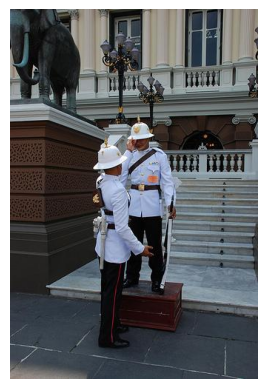

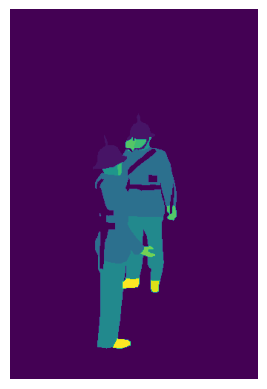

In [7]:
img = plt.imread(train_img[0])
mask = plt.imread(train_mask[0])

plt.imshow(img)
plt.axis("off")
plt.show()

plt.imshow(mask)
plt.axis("off")
plt.show()

In [8]:
def read_img(img_path, mask = False):
    image = tf.io.read_file(img_path)

    if mask:
        image = tf.image.decode_png(image, channels = 1)
        image.set_shape([None, None, 1])
        image = tf.image.resize(image, [img_size, img_size])

    else :
        image = tf.image.decode_png(image, channels = 3)
        image.set_shape([None, None, 3])
        image = tf.image.resize(image, [img_size, img_size])

    return image


def load_data(img_path, mask_path):
    image = read_img(img_path)
    mask = read_img(mask_path, mask = True)
    return image, mask


def prepare_dataset(images, masks):
    dataset = tf.data.Dataset.from_tensor_slices((images, masks))
    dataset = dataset.map(load_data, num_parallel_calls = tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    return dataset

In [9]:
train_data = prepare_dataset(train_img, train_mask)
valid_data = prepare_dataset(val_img, val_mask)

print(train_data.element_spec)
print(valid_data.element_spec)

(TensorSpec(shape=(4, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4, 256, 256, 1), dtype=tf.float32, name=None))
(TensorSpec(shape=(4, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4, 256, 256, 1), dtype=tf.float32, name=None))


## Building the DeepLabV3+ model

DeepLabv3+ extends DeepLabv3 by adding an encoder-decoder structure. The encoder module
processes multiscale contextual information by applying dilated convolution at multiple
scales, while the decoder module refines the segmentation results along object boundaries.

![](https://github.com/lattice-ai/DeepLabV3-Plus/raw/master/assets/deeplabv3_plus_diagram.png)

**Dilated convolution:** With dilated convolution, as we go deeper in the network, we can keep the
stride constant but with larger field-of-view without increasing the number of parameters
or the amount of computation. Besides, it enables larger output feature maps, which is
useful for semantic segmentation.

The reason for using **Dilated Spatial Pyramid Pooling** is that it was shown that as the
sampling rate becomes larger, the number of valid filter weights (i.e., weights that
are applied to the valid feature region, instead of padded zeros) becomes smaller.

In [10]:
def conv_block(inputs, n_filters = 256, kernel_size = 3, dilation_rate = 1, use_bias = False):
    x = layers.Conv2D(n_filters, kernel_size = kernel_size, padding = "same", dilation_rate = dilation_rate, use_bias = use_bias, kernel_initializer = keras.initializers.HeNormal())(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    return x



def DilatedSpatialPyramidPooling(inputs):
    dims = inputs.shape
    x = layers.AveragePooling2D(pool_size = (dims[-3], dims[-2]))(inputs)
    x = conv_block(x, kernel_size = 1, use_bias = True)

    out_pool = layers.UpSampling2D(size = (dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation = "bilinear")(x)
    out_1 = conv_block(inputs, kernel_size = 1, dilation_rate = 1)
    out_6 = conv_block(inputs, kernel_size = 3, dilation_rate = 6)
    out_12 = conv_block(inputs, kernel_size = 3, dilation_rate = 12)
    out_18 = conv_block(inputs, kernel_size = 3, dilation_rate = 18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    outputs = conv_block(x, kernel_size = 1)
    return outputs

The encoder features are first bilinearly upsampled by a factor 4, and then
concatenated with the corresponding low-level features from the network backbone that
have the same spatial resolution. For this example, we
use a ResNet50 pretrained on ImageNet as the backbone model, and we use
the low-level features from the `conv4_block6_2_relu` block of the backbone.

In [11]:
def DeepLabv3plus(img_size, num_classes):
    inputs = keras.Input(shape = (img_size, img_size, 3))
    preprocess = keras.applications.resnet50.preprocess_input(inputs)
    backbone = keras.applications.ResNet50(include_top = False, weights = "imagenet", input_tensor = preprocess)
    x = backbone.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_A = layers.UpSampling2D(size = (img_size // 4 // x.shape[1], img_size // 4 // x.shape[2]), interpolation = "bilinear")(x)
    input_B = backbone.get_layer("conv2_block3_2_relu").output
    input_B = conv_block(input_B, n_filters = 48, kernel_size = 1)

    x = layers.Concatenate(axis=-1)([input_A, input_B])
    x = conv_block(x)
    x = conv_block(x)
    x = layers.UpSampling2D(size = (img_size // x.shape[1], img_size // x.shape[2]), interpolation = "bilinear")(x)

    outputs = layers.Conv2D(num_classes, kernel_size = 1, padding = "same")(x)

    model = keras.Model(inputs, outputs)
    return model

In [12]:
model = DeepLabv3plus(img_size, num_classes)
model.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 tf.__operators__.getitem (  (None, 256, 256, 3)          0         ['input_1[0][0]']             
 SlicingOpLambda)                                                                                 
                                                                                                  
 tf.nn.bias_add (TFOpLambda  (None, 256, 256, 3)          0         ['tf.__operators__.getitem[0][
 )                                                                  0]']                          
                             

Epoch 1/50
250/250 [==============================] - 81s 116ms/step - loss: 1.2235 - accuracy: 0.6368 - val_loss: 1.2366 - val_accuracy: 0.6291
Epoch 2/50
250/250 [==============================] - 29s 115ms/step - loss: 0.9732 - accuracy: 0.6925 - val_loss: 1.0500 - val_accuracy: 0.6734
Epoch 3/50
250/250 [==============================] - 29s 115ms/step - loss: 0.8599 - accuracy: 0.7278 - val_loss: 1.0114 - val_accuracy: 0.6864
Epoch 4/50
250/250 [==============================] - 29s 115ms/step - loss: 0.7912 - accuracy: 0.7474 - val_loss: 0.8946 - val_accuracy: 0.7126
Epoch 5/50
250/250 [==============================] - 29s 115ms/step - loss: 0.7678 - accuracy: 0.7536 - val_loss: 0.8723 - val_accuracy: 0.7250
Epoch 6/50
250/250 [==============================] - 29s 115ms/step - loss: 0.6976 - accuracy: 0.7772 - val_loss: 0.9149 - val_accuracy: 0.7161
Epoch 7/50
250/250 [==============================] - 31s 123ms/step - loss: 0.6297 - accuracy: 0.8002 - val_loss: 0.8727 - val_ac

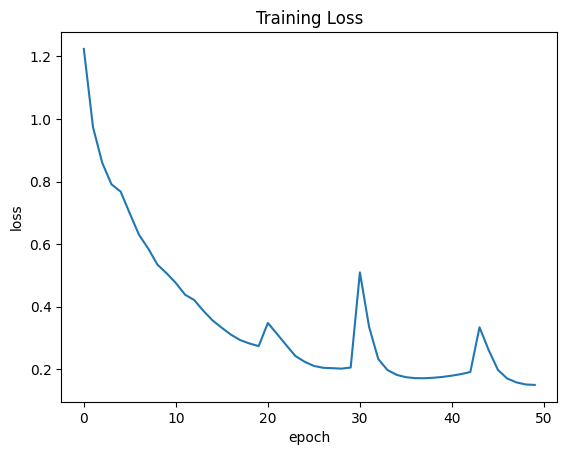

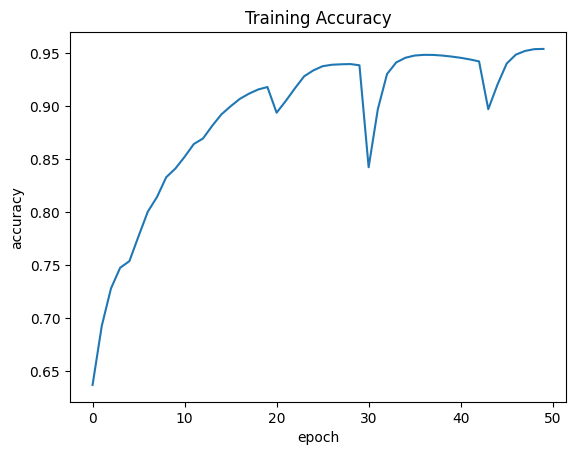

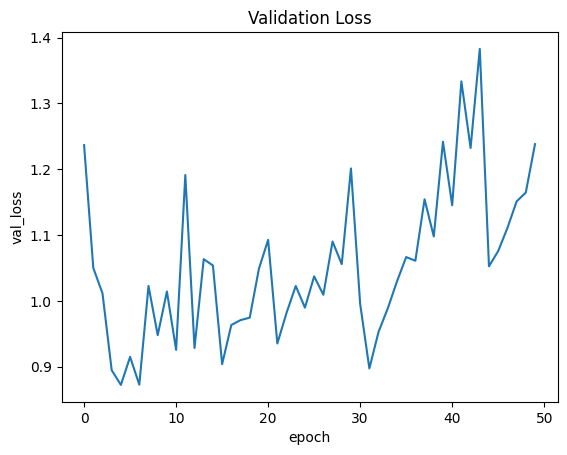

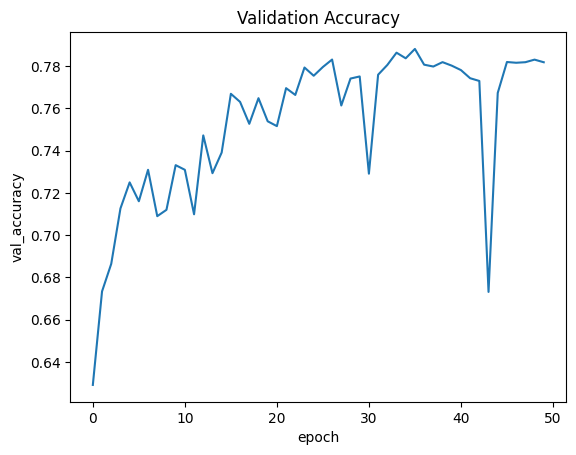

In [13]:
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=loss,
    metrics=["accuracy"])

history = model.fit(train_data, validation_data=valid_data, epochs=50)

plt.plot(history.history["loss"])
plt.title("Training Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["accuracy"])
plt.title("Training Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_loss"])
plt.title("Validation Loss")
plt.ylabel("val_loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_accuracy"])
plt.title("Validation Accuracy")
plt.ylabel("val_accuracy")
plt.xlabel("epoch")
plt.show()

In [14]:
# Loading the Colormap
colormap = loadmat("/content/instance-level_human_parsing/instance-level_human_parsing/human_colormap.mat")["colormap"]
colormap = colormap * 100
colormap = colormap.astype(np.uint8)


def infer(model, image_tensor):
    predictions = model.predict(np.expand_dims((image_tensor), axis=0))
    predictions = np.squeeze(predictions)
    predictions = np.argmax(predictions, axis=2)
    return predictions


def decode_segmentation_masks(mask, colormap, n_classes):
    r = np.zeros_like(mask).astype(np.uint8)
    g = np.zeros_like(mask).astype(np.uint8)
    b = np.zeros_like(mask).astype(np.uint8)
    for l in range(0, n_classes):
        idx = mask == l
        r[idx] = colormap[l, 0]
        g[idx] = colormap[l, 1]
        b[idx] = colormap[l, 2]
    rgb = np.stack([r, g, b], axis=2)
    return rgb


def get_overlay(image, colored_mask):
    image = keras.utils.array_to_img(image)
    image = np.array(image).astype(np.uint8)
    overlay = cv2.addWeighted(image, 0.35, colored_mask, 0.65, 0)
    return overlay


def plot_samples_matplotlib(display_list, figsize=(5, 3)):
    _, axes = plt.subplots(nrows=1, ncols=len(display_list), figsize=figsize)
    for i in range(len(display_list)):
        if display_list[i].shape[-1] == 3:
            axes[i].imshow(keras.utils.array_to_img(display_list[i]))
        else:
            axes[i].imshow(display_list[i])
    plt.show()


def plot_predictions(images_list, colormap, model):
    for image_file in images_list:
        image_tensor = read_img(image_file)
        prediction_mask = infer(image_tensor=image_tensor, model=model)
        prediction_colormap = decode_segmentation_masks(prediction_mask, colormap, 20)
        overlay = get_overlay(image_tensor, prediction_colormap)
        plot_samples_matplotlib(
            [image_tensor, overlay, prediction_colormap], figsize=(18, 14)
        )

1/1 [==============================] - 3s 3s/step


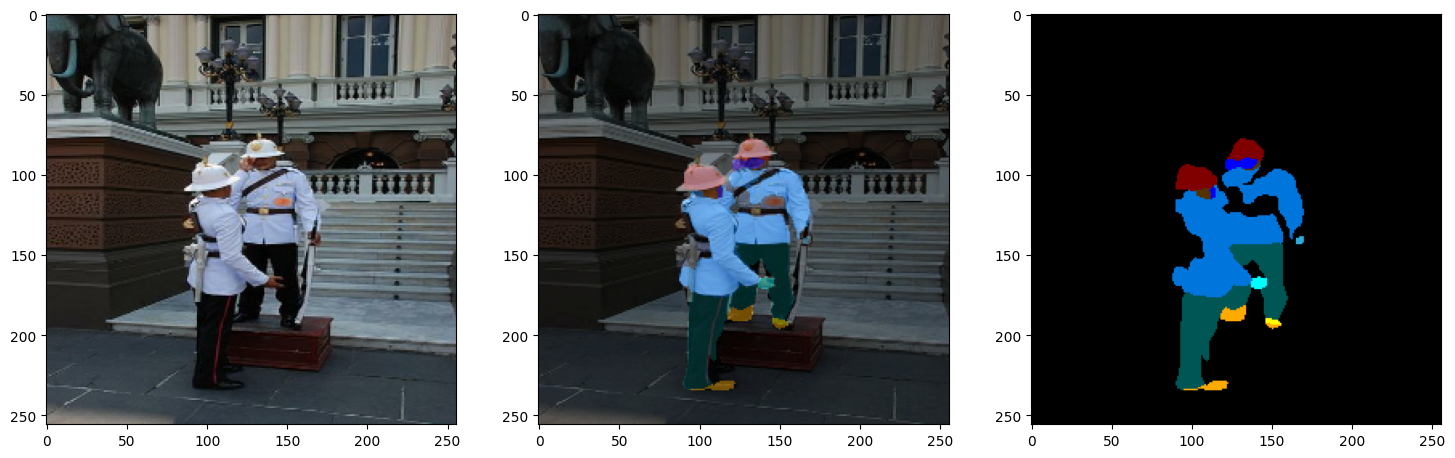

1/1 [==============================] - 0s 35ms/step


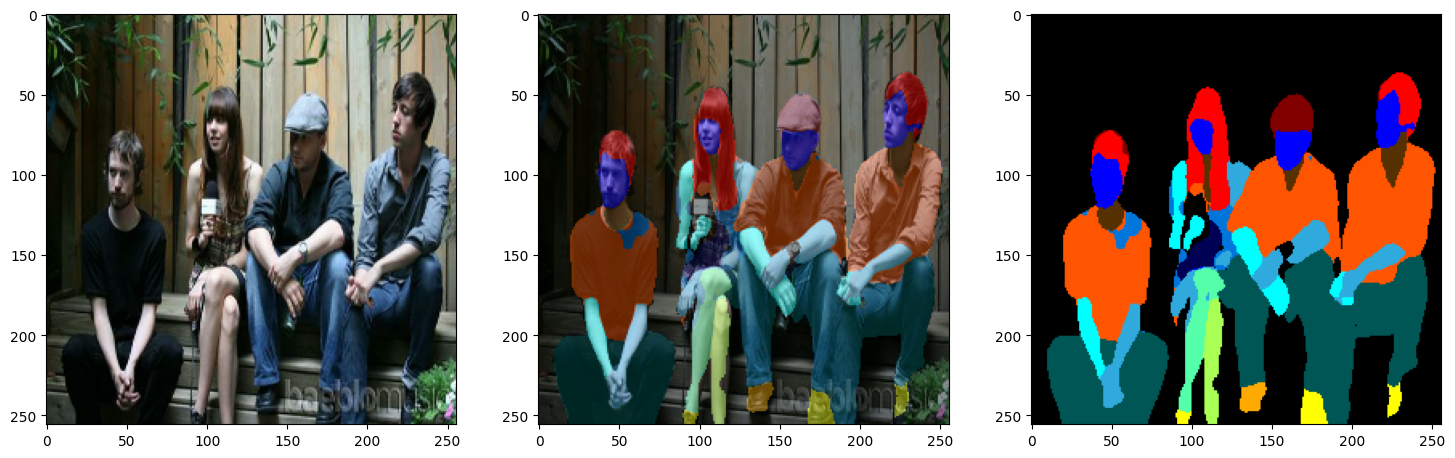

1/1 [==============================] - 0s 38ms/step


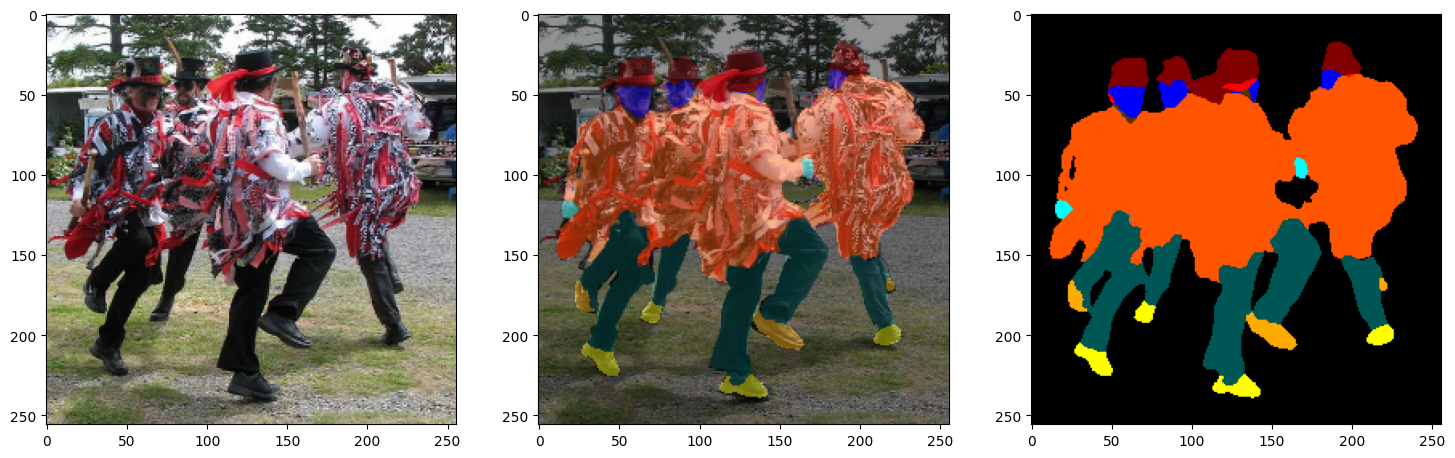

1/1 [==============================] - 0s 44ms/step


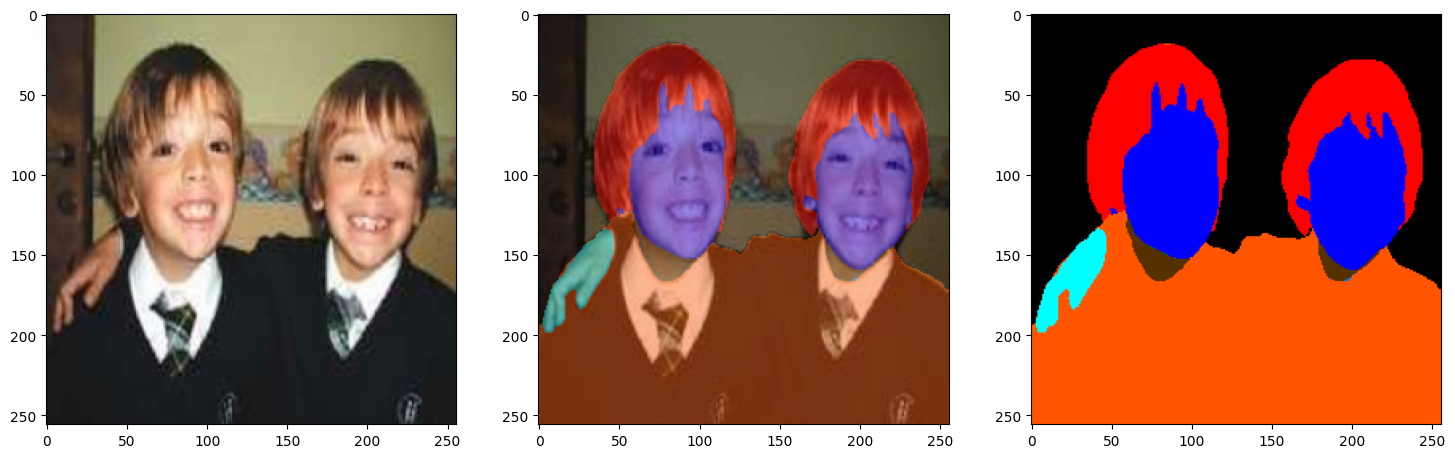

In [15]:
plot_predictions(train_img[:4], colormap, model)

1/1 [==============================] - 0s 47ms/step


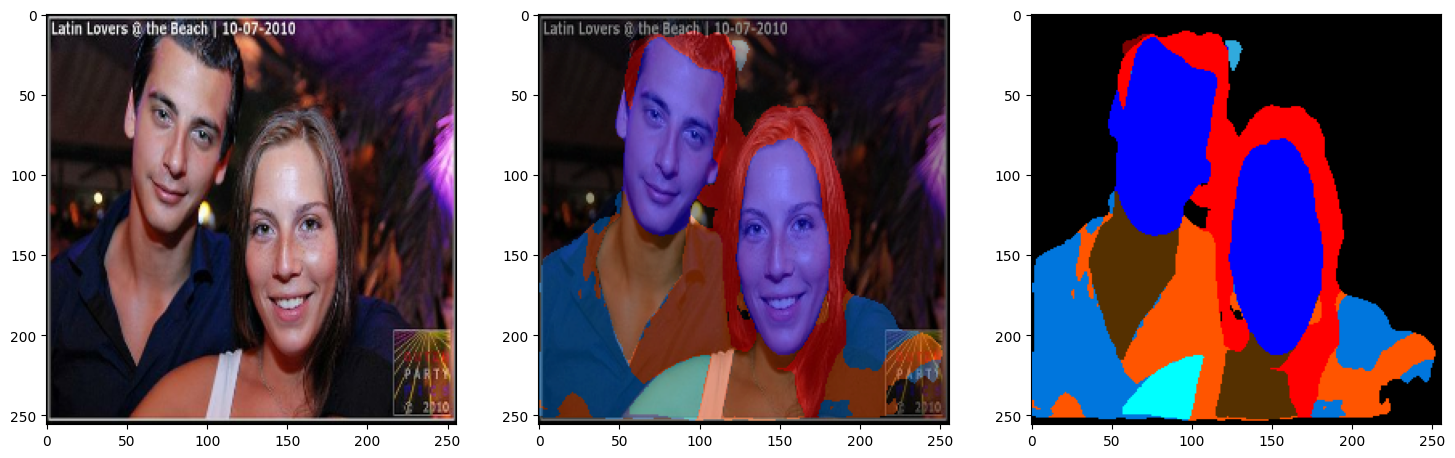

1/1 [==============================] - 0s 43ms/step


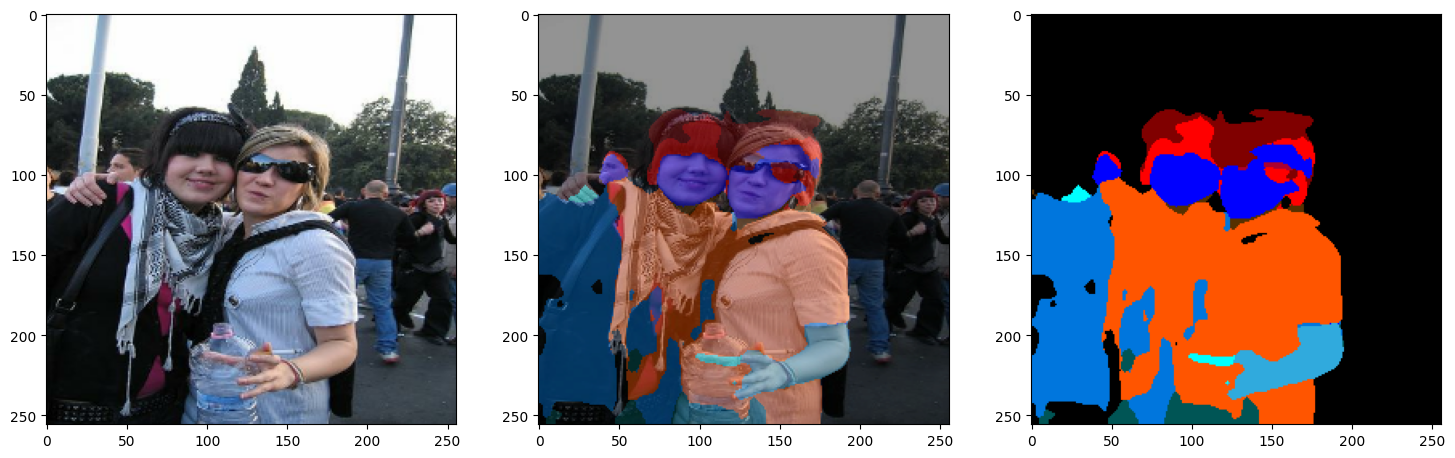

1/1 [==============================] - 0s 34ms/step


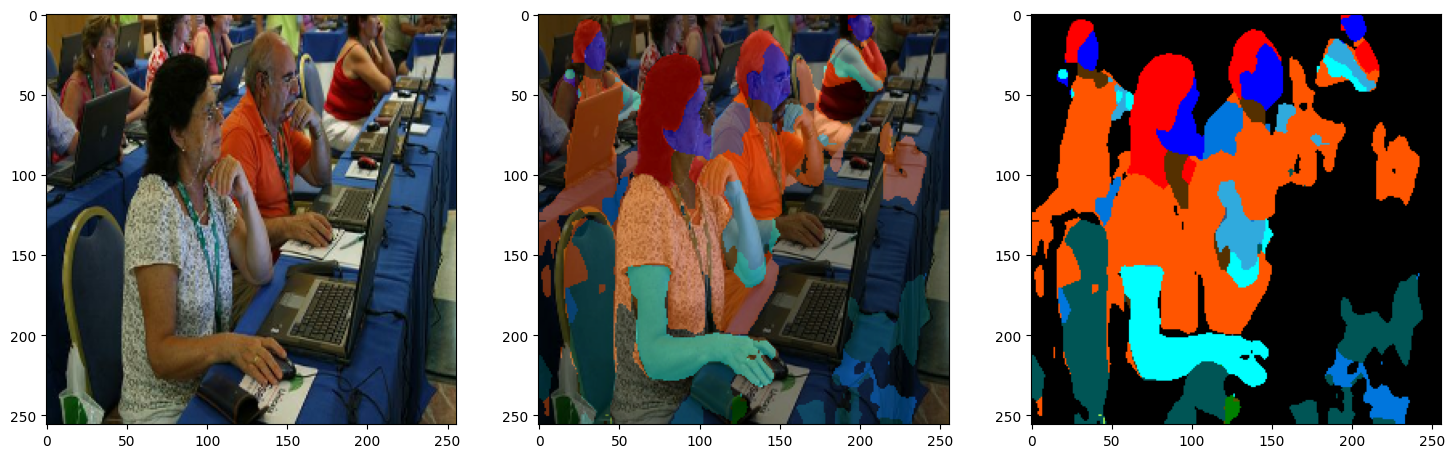

1/1 [==============================] - 0s 51ms/step


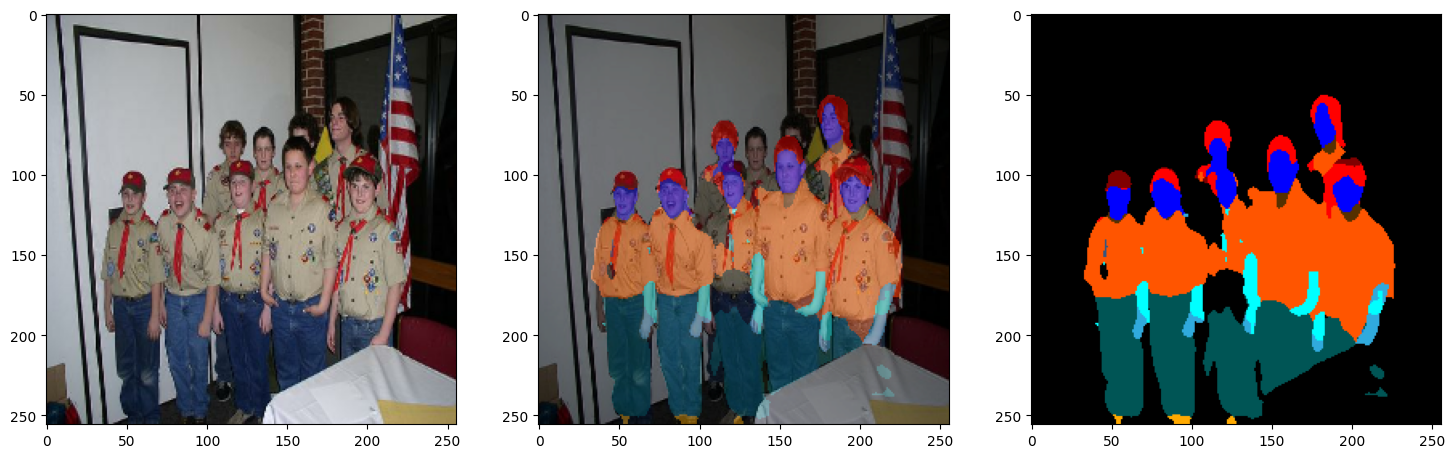

In [16]:
plot_predictions(val_img[:4], colormap, model=model)